# Descriptive Analysis

Loading necessary libraries

In [3]:
import pandas as pd 
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import logging
logging.basicConfig(
    level= logging.INFO,
    format= "%(asctime)s - %(levelname)s - %(message)s"
)

Loading the clean data from parquet files

In [4]:
anki: pd.DataFrame = pd.read_parquet("../data/clean_anki.parquet")
flowmodoro: pd.DataFrame = pd.read_parquet("../data/clean_flowmodoro.parquet")
bir: pd.DataFrame = pd.read_parquet("../data/clean_bir.parquet")
logging.info("Loadded parquet files into dataframes")

2025-11-19 11:11:05,482 - INFO - Loadded parquet files into dataframes


## Parameters

### Total time

In [5]:
total_mins_bir: float = bir.sum().sum()
total_hours_bir: float = round(total_mins_bir / 60, 2)
print(f"Total time spent studying for bir = {total_hours_bir}")

Total time spent studying for bir = 774.4


### Time spent by activity

In [6]:
total_by_act: pd.DataFrame = round(bir.sum() / 60, 1).reset_index()
total_by_act["activity"] = total_by_act["activity"].map({
    "01_own": "Anki",
    "active_recall": "Active Recall",
    "admin": "Admin",
    "anki_craft": "Anki Craft",
    "bhs": "BHS sys",
    "lectures": "Lectures",
    "exam_anki": "Exam Qs"
})
total_by_act = total_by_act.rename(columns={0: "time"})

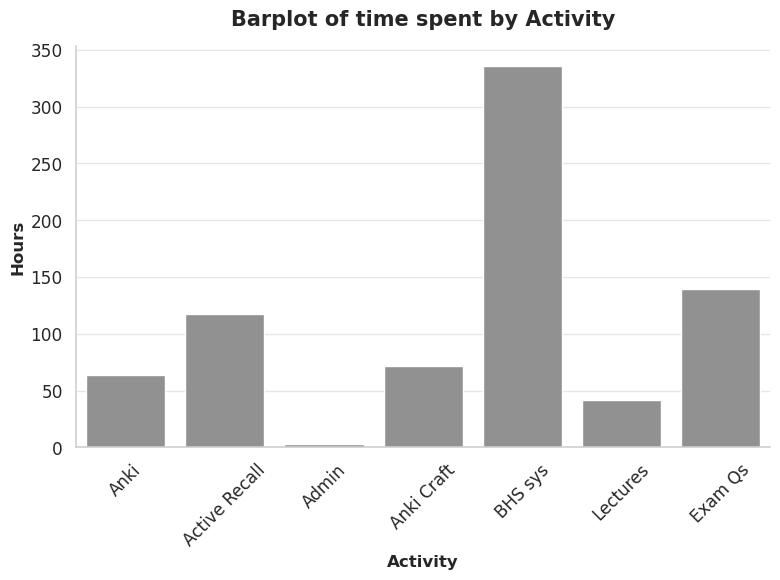

In [7]:
sns.set_theme(style="white", font_scale=1.1, rc={
    "axes.edgecolor": "0.8",
    "axes.linewidth": 1.1,
    "grid.color": "0.9",
    "axes.labelweight": "bold"
})

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=total_by_act,
    x="activity",
    y="time",
    color="#919191F1", 
    edgecolor=None
)

ax.set_xlabel("Activity", fontsize=12, weight='bold')
ax.set_ylabel("Hours", fontsize=12, weight='bold')
ax.set_title("Barplot of time spent by Activity", fontsize=15, weight='bold', pad=15)
ax.tick_params(axis='x', rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('0.8')
ax.spines['bottom'].set_color('0.8')
ax.grid(axis='y', color='0.9', linewidth=1)
ax.grid(axis='x', visible=False)

plt.tight_layout()
plt.savefig("../images/barplot_time_activity.png", dpi=300, bbox_inches="tight")
plt.show()

### Cumulative time per week and activity

Lets create a dataframe grouped by week 

In [8]:
bir_by_date: pd.DataFrame = bir.reset_index().copy()
bir_by_date["date_day"] = pd.to_datetime(bir_by_date["date_day"])
bir_by_date["total_mins"] = bir_by_date.drop(columns="date_day").sum(axis=1)
bir_by_date["total_hours"] = bir_by_date["total_mins"] / 60
bir_gr_week = bir_by_date.copy()
bir_gr_week["week"] = bir_gr_week["date_day"].dt.to_period("W")
bir_gr_week = bir_gr_week.drop(columns=["date_day"])
bir_gr_week = bir_gr_week.groupby("week").sum()
bir_gr_week = bir_gr_week.rename(columns= {
    "01_own": "Anki",
    "active_recall": "Active Recall",
    "admin": "Admin",
    "anki_craft": "Anki Craft",
    "bhs": "BHS sys",
    "lectures": "Lectures",
    "exam_anki": "Exam Qs",
    "total_mins": "Total Hours"
})
bir_gr_week = bir_gr_week.drop(columns=["total_hours"])

In [9]:
activity_cols: list = [c for c in bir_gr_week.columns if c not in {"week"}]
bir_gr_week_cumsum: pd.DataFrame = bir_gr_week.copy()
bir_gr_week_cumsum[activity_cols] = bir_gr_week_cumsum[activity_cols].cumsum().div(60)

2025-11-19 11:11:06,995 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-19 11:11:07,010 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


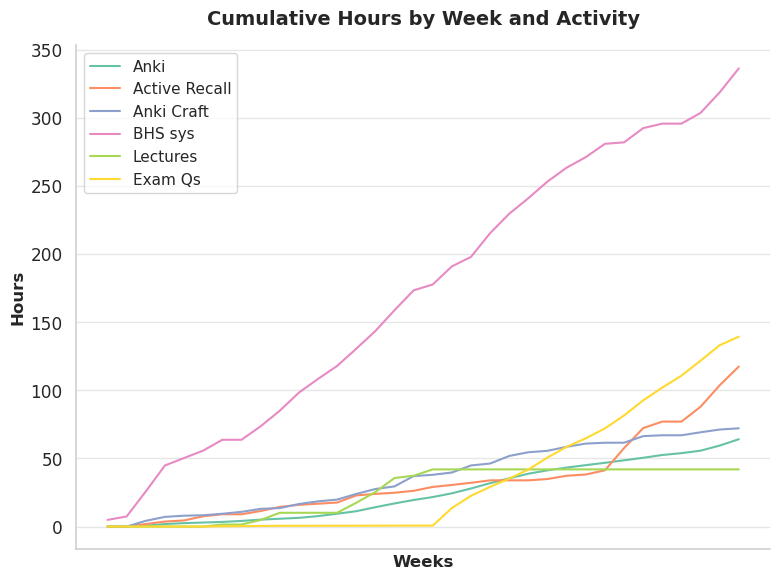

In [10]:
plot_cols: list = [c for c in bir_gr_week_cumsum.columns if c not in {"week", "Total Hours", "Admin"}]

df_long = bir_gr_week_cumsum.reset_index() \
                              .melt(id_vars='week',
                                    value_vars=plot_cols,
                                    var_name='activity',
                                    value_name='hours')

df_long['week'] = df_long['week'].astype(str)
df_long['activity'] = df_long['activity'].astype(str)
df_long = df_long.reset_index(drop=True)


plt.figure(figsize=(8, 6))
ax = sns.lineplot(
        data=df_long,
        x='week',
        y='hours',
        hue='activity',
        linewidth=1.5,
        palette='Set2'
)

ax.set_xlabel("Weeks", fontsize=12)
ax.set_ylabel("Hours", fontsize=12)
ax.set_title("Cumulative Hours by Week and Activity", fontsize=14, weight="bold", pad= 15)
ax.legend(title="", loc="upper left", fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('0.8')
ax.spines['bottom'].set_color('0.8')
ax.grid(axis='y', color='0.9', linewidth=1)
ax.grid(axis='x', visible=False)
ax.set_xticks([])

plt.tight_layout()
plt.savefig("../images/lineplot_cumsum_time_activites.png", dpi=300, bbox_inches="tight")
plt.show()

2025-11-19 11:11:08,443 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-19 11:11:08,467 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


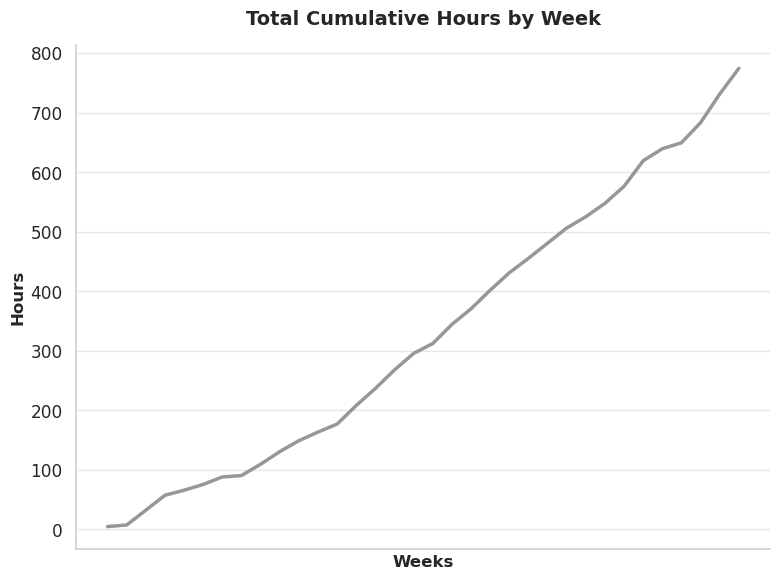

In [11]:
bir_gr_week_cumsum.index = bir_gr_week_cumsum.index.astype(str)

sns.set_theme(
    style="white",
    font_scale=1.1,
    rc={
        "axes.edgecolor": "0.8",
        "axes.linewidth": 1.1,
        "grid.color": "0.9",
        "axes.labelweight": "bold"
    }
)

plt.figure(figsize=(8, 6))
ax = sns.lineplot(
    x=bir_gr_week_cumsum.index,
    y=bir_gr_week_cumsum["Total Hours"],
    color="#919191F1", 
    linewidth=2.5,
)

ax.set_xlabel("Weeks", fontsize=12)
ax.set_ylabel("Hours", fontsize=12)
ax.set_title("Total Cumulative Hours by Week", fontsize=14, weight="bold", pad= 15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('0.8')
ax.spines['bottom'].set_color('0.8')
ax.grid(axis='y', color='0.9', linewidth=1)
ax.grid(axis='x', visible=False)
ax.set_xticks([])

plt.tight_layout()
plt.savefig("../images/lineplot_cumsum_time.png", dpi=300, bbox_inches="tight")
plt.show()

### Daily mean vs median study time

First lets create a dataframe with the total time per day

In [12]:
bir_days_hours: pd.DataFrame = bir_by_date.copy()
bir_days_hours = bir_days_hours[["date_day","total_hours"]]

Lets calculate the mean and median per day

In [13]:
mean_h: float = bir_days_hours["total_hours"].mean()
median_h: float = bir_days_hours["total_hours"].median()
print(f"Mean hourns per day: {mean_h:.2f}")
print(f"Median hourns per day: {median_h:.2f}")

Mean hourns per day: 3.40
Median hourns per day: 2.99


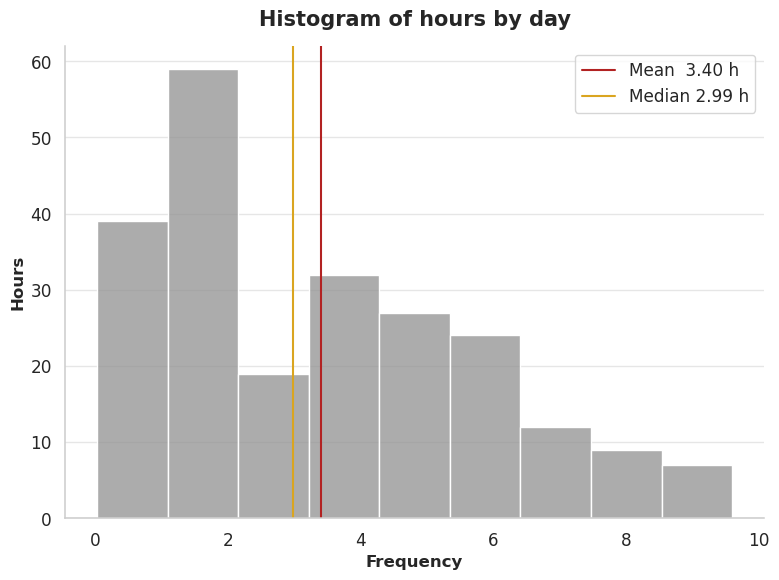

In [14]:
sns.set_theme(style="white", font_scale=1.1, rc={
    "axes.edgecolor": "0.8",
    "axes.linewidth": 1.1,
    "grid.color": "0.9",
    "axes.labelweight": "bold"
})

plt.figure(figsize=(8, 6))
ax = sns.histplot(
    data = bir_days_hours,
    x = "total_hours",
    bins = "auto",
    kde = False,
    color = "#919191F1"
)

ax.axvline(mean_h, color="firebrick", ls='-', lw=1.5, label=f"Mean  {mean_h:.2f} h")
ax.axvline(median_h, color="goldenrod", ls="-", lw=1.5, label=f"Median {median_h:.2f} h")

ax.legend()
ax.set_xlabel("Frequency", fontsize=12, weight='bold')
ax.set_ylabel("Hours", fontsize=12, weight='bold')
ax.set_title("Histogram of hours by day", fontsize=15, weight='bold', pad=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('0.8')
ax.spines['bottom'].set_color('0.8')
ax.grid(axis='y', color='0.9', linewidth=1)
ax.grid(axis='x', visible=False)

plt.tight_layout()
plt.savefig("../images/histogram_hours_per_day.png", dpi=300, bbox_inches="tight")
plt.show()

Interpretación

### Efective study days

In [15]:
num_days: int = (datetime(year= 2025, month=1, day=25) - datetime(year= 2024, month=6, day=16)).days + 1
num_days_recorded: int = len(bir_by_date.loc[4:]) 

print(f"The % of efective days is: {(num_days_recorded/num_days)*100:.0f}%")
print(f"Meaning the streak was held for all the {num_days} days")

The % of efective days is: 100%
Meaning the streak was held for all the 224 days


### Standard deviation of daily study time

In [16]:
std_hours_studied: float = bir_days_hours["total_hours"].std(ddof=0)

print(f"The standard deviation of daily study time is: {std_hours_studied:.2f} hours")

The standard deviation of daily study time is: 2.41 hours


### Highest and lowest single-day study time

In [17]:
idx_min_day: int | str = bir_days_hours["total_hours"].idxmin()
idx_max_day: int | str = bir_days_hours["total_hours"].idxmax()

min_day_row: pd.DataFrame | pd.Series = bir_days_hours.loc[idx_min_day]
max_day_row: pd.DataFrame | pd.Series = bir_days_hours.loc[idx_max_day]

print(f"Day with the least time studied: {min_day_row["date_day"]} with {min_day_row["total_hours"]:.2f} hours of study time")
print(f"Day with the most time studied: {max_day_row["date_day"]} with {max_day_row["total_hours"]:.2f} hours of study time")

Day with the least time studied: 2024-07-06 00:00:00 with 0.03 hours of study time
Day with the most time studied: 2025-01-16 00:00:00 with 9.59 hours of study time


### Most and least productive week

In [18]:
idx_min_week: int | str = bir_gr_week["Total Hours"].idxmin()
idx_max_week: int | str = bir_gr_week["Total Hours"].idxmax()

min_week_row: pd.DataFrame | pd.Series = bir_gr_week.loc[idx_min_week]
max_week_row: pd.DataFrame | pd.Series = bir_gr_week.loc[idx_max_week]

print(f"Week with the least time studied: {idx_min_week} with {(min_week_row["Total Hours"] / 60):.2f} hours of study time")
print(f"Week with the most time studied: {idx_max_week} with {(max_week_row["Total Hours"] / 60):.2f} hours of study time")

Week with the least time studied: 2024-07-22/2024-07-28 with 2.26 hours of study time
Week with the most time studied: 2025-01-13/2025-01-19 with 47.97 hours of study time


# Main Questions to Answer

## Wich hours of the day was I more productive?

To answer this question I will create a heatmap where the x parameter is the week days and the y parameter is time spent doing some of the activities

The dataframe needed to answer this question will contain 5 columns:

- `date` being the date in YYYY/MM/DD
- `day_name` being the name of the day
- `hour` bucket containing 1h of the day starting from 5am ending in 1am
- `activity` what was I doing
- `minutes` for how long was I doning it

To achive this I will use the anki dataframe and flowmodor dataframe that has the appropiate info, transform them and merge to achive the desired dataframe

In [19]:
anki_hm: pd.DataFrame = anki.copy()
flow_hm: pd.DataFrame = flowmodoro.copy()

anki_hm = anki_hm.drop(columns=["note_id", "card_id", "tags_list", "pressed", "date_day"])
flow_hm = flow_hm.drop(columns=["accomplished"])

anki_hm["date_reviewed"] = pd.to_datetime(anki_hm["date_reviewed"])
flow_hm["started"] = pd.to_datetime(flow_hm["started"])

In [20]:
anki_hm["date"] = anki_hm["date_reviewed"].dt.date
anki_hm["day_name"] = anki_hm["date_reviewed"].dt.day_name()

flow_hm["date"] = flow_hm["started"].dt.date
flow_hm["day_name"] = flow_hm["started"].dt.day_name()

To simplify the code, and since the anki max response time is 60 seconds, the anki data will be assumed that does not cross hours this way we only need to get the hour started, group by hour and day, sum the seconds and transfrom into minutes

In [21]:
anki_hm["hour"] = anki_hm["date_reviewed"].dt.hour
anki_hm = anki_hm.drop(columns=["date_reviewed"])

In [22]:
anki_hm_gr = (anki_hm.groupby(["date", "day_name", "hour", "deck"], as_index=False)["review_time_seconds"].sum())
anki_hm_gr["review_time_seconds"] = anki_hm_gr["review_time_seconds"].div(60)
anki_hm_gr = anki_hm_gr.rename(columns={"review_time_seconds": "minutes", "deck": "activity"})
# anki_hm_gr["minutes"] = np.floor(anki_hm_gr["minutes"])
anki_hm_gr["activity"] = anki_hm_gr["activity"].map({
    "01_own": "Anki_Review",
    "02_exam": "Anki_Exam_Q",
})
anki_hm_gr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      1549 non-null   object 
 1   day_name  1549 non-null   object 
 2   hour      1549 non-null   int32  
 3   activity  1549 non-null   object 
 4   minutes   1549 non-null   float64
dtypes: float64(1), int32(1), object(3)
memory usage: 54.6+ KB


For flowmodoro data we need to account that the time spent can be split between more that one hour bucket

In [23]:
flow_hm["end"] = flow_hm["started"] + pd.to_timedelta(flow_hm["mins_worked"], unit="minutes")
flow_hm["hour"] = flow_hm["started"].dt.hour

In [24]:
def split_buckets(row: pd.Series) -> list:
    buckets: list = []
    ts_start: pd.Timestamp = row["started"]
    ts_end: pd.Timestamp = row["end"]
    h_curr: pd.Timestamp = ts_start.floor("h")
    while h_curr < ts_end:
        h_next = h_curr + timedelta(hours=1)
        mins_in = int(
            (min(ts_end, h_next) - max(ts_start, h_curr)).total_seconds() / 60
        )
        buckets.append({
            "date": h_curr.date(),
            "day_name": h_curr.day_name(),
            "hour": h_curr.hour,
            "activity": row["working_on"],
            "minutes": mins_in
        })
        h_curr = h_next
    return buckets

In [25]:
hour_buckets = flow_hm.apply(split_buckets, axis=1).explode(ignore_index=True)
flow_hm_buckets = pd.DataFrame(hour_buckets.tolist())

flow_hm_gr = (flow_hm_buckets.groupby(["date", "day_name", "hour", "activity"], as_index=False)["minutes"].sum())
flow_hm_gr["minutes"] = flow_hm_gr["minutes"].astype(float)
flow_hm_gr["activity"] = flow_hm_gr["activity"].map({
    "active_recall": "Active Recall",
    "admin": "Admin",
    "anki_craft": "Anki Craft",
    "bhs": "BHS sys",
    "lectures": "Lectures",
    "anki_exam": "Exam Qs"
})

flow_hm_gr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329 entries, 0 to 1328
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      1329 non-null   object 
 1   day_name  1329 non-null   object 
 2   hour      1329 non-null   int64  
 3   activity  1329 non-null   object 
 4   minutes   1329 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 52.0+ KB


Now that booth df have the same structure lets merge them

In [26]:
hm_df: pd.Series = pd.concat([anki_hm_gr, flow_hm_gr], ignore_index=True)
hm_df["hours"] = hm_df["minutes"] /60
hm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2878 entries, 0 to 2877
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      2878 non-null   object 
 1   day_name  2878 non-null   object 
 2   hour      2878 non-null   int64  
 3   activity  2878 non-null   object 
 4   minutes   2878 non-null   float64
 5   hours     2878 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 135.0+ KB


Finally lets do the heatmap

### Global Heatmap

To do the heatmap lets pivot the dataframe to obtain a dataframe where the columns are the hour buckets, the rows are the weekdays 

In [27]:
pivot_total: pd.DataFrame = (hm_df.pivot_table(index='hour',
                              columns='day_name',
                              values='hours',
                              aggfunc='sum')
                .reindex(columns=['Monday', 'Tuesday', 'Wednesday',
                      'Thursday', 'Friday', 'Saturday', 'Sunday'])
                .reindex(index=range(5, 24)))

pivot_norm: pd.DataFrame = pivot_total.div(pivot_total.max().max()) 
pivot_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 5 to 23
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Monday     17 non-null     float64
 1   Tuesday    17 non-null     float64
 2   Wednesday  18 non-null     float64
 3   Thursday   18 non-null     float64
 4   Friday     18 non-null     float64
 5   Saturday   18 non-null     float64
 6   Sunday     17 non-null     float64
dtypes: float64(7)
memory usage: 1.2 KB


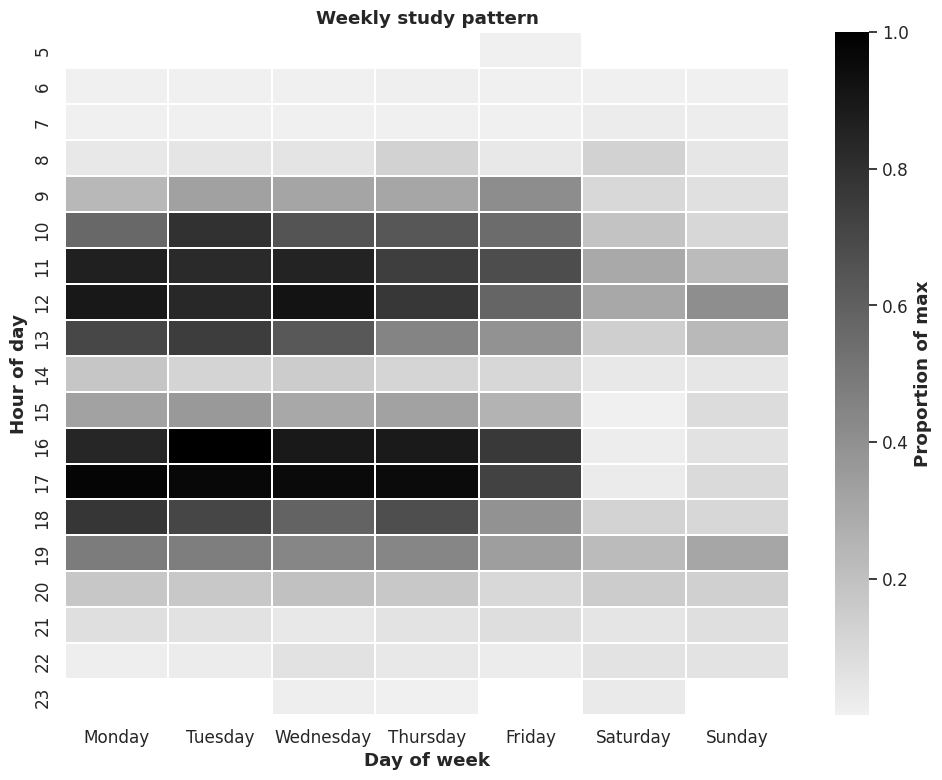

In [29]:
grey_grad = LinearSegmentedColormap.from_list(
    "grey_grad",
    ["#F0F0F0",
     '#000000']
)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_norm,
            cmap=grey_grad,
            linewidths=.3,
            cbar_kws={"label": "Proportion of max"})
plt.ylabel("Hour of day")
plt.xlabel("Day of week")
plt.title("Weekly study pattern", weight="bold")
plt.tight_layout()
plt.savefig("../images/heatmap_global.png", dpi= 300)
plt.show()

Comentario + visual, mas buscar en el df franja horaria mas productiva y top 5